## QA over unstructured data

Using Match LSTM, Pointer Networks, as mentioned in paper https://arxiv.org/pdf/1608.07905.pdf

We start with the pre-processing provided by https://github.com/MurtyShikhar/Question-Answering to clean up the data and make neat para, ques files.


### @TODOs:

1. [done] _Figure out how to put in real, pre-trained embeddings in embeddings layer._
2. [done] _Explicitly provide batch size when instantiating model_
3. is ./val.ids.* validation set or test set?: **validation**
4. [done:em] emInstead of test loss, calculate test acc metrics
    1. todo: new metrics like P, R, F1
5. Update unit test codes

In [1]:
# # Codeblock to pull up embeddings. Needs to run before following imports
# import numpy as np

# # Macros 
# DATA_LOC = './data/squad/'
# EMBEDDING_FILE = 'glove.trimmed.300.npz'
# VOCAB_FILE = 'vocab.dat'

# file_loc = DATA_LOC + EMBEDDING_FILE
# glove_file = np.load(open(file_loc))['glove']

In [2]:
from __future__ import unicode_literals, print_function, division
import matplotlib.pyplot as plt
from io import open
import numpy as np
import unicodedata
import traceback
import string
import random
import time
import re
import os


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda")

torch.manual_seed(42)
np.random.seed(42)

#### Debug Legend

- 5: Print everything that goes in every tensor.
- 4: ??
- 3: Check every model individually
- 2: Print things in training loops
- 1: ??

In [3]:
# Macros 
DATA_LOC = './data/squad/'
DEBUG = 2

# nn Macros
QUES_LEN, PARA_LEN =  30, 200
VOCAB_SIZE = 120000
# VOCAB_SIZE = glove_file.shape[1]               # @TODO: get actual size
HIDDEN_DIM = 150
EMBEDDING_DIM = 300
BATCH_SIZE = 20                  # Might have total 100 batches.
EPOCHS = 100
TEST_EVERY_ = 1
LR = 0.01
CROP = 200

### Encoder 
Use a simple lstm class to have encoder for question and paragraph. 
The output of these will be used in the match lstm

$H^p = LSTM(P)$ 


$H^q = LSTM(Q)$

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, inputlen, macros, glove_file):
        super(Encoder, self).__init__()
        
        # Catch dim
        self.inputlen = inputlen
        self.hiddendim = macros['hidden_dim']
        self.embeddingdim =  macros['embedding_dim']
        self.vocablen = macros['vocab_size']
        
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']
        
        # Embedding Layer
#         self.embedding = nn.Embedding(self.vocablen, self.embeddingdim)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(glove_file))
        self.embedding.weight.requires_grad = True
       
        # LSTM Layer
        self.lstm = nn.LSTM(self.embeddingdim, self.hiddendim)
        
    def init_hidden(self, batch_size):
        
        # Returns a new hidden layer var for LSTM
        return (torch.zeros((1, batch_size, self.hiddendim), device=device), 
                torch.zeros((1, batch_size, self.hiddendim), device=device))
    
    def forward(self, x, h):
        
        # Input: x (batch, len ) (current input)
        # Hidden: h (1, batch, hiddendim) (last hidden state)
        
        # Batchsize: b int (inferred)
        b = x.shape[0]
        
        if self.debug > 4: print("x:\t", x.shape)
        if self.debug > 4: print("h:\t", h[0].shape, h[1].shape)
        
        x_emb = self.embedding(x)
        if self.debug > 4: print("x_emb:\t", x_emb.shape)
            
        ycap, h = self.lstm(x_emb.view(-1, b, self.embeddingdim), h)
        if self.debug > 4: print("ycap:\t", ycap.shape)
        
        return ycap, h
    
    
# with torch.no_grad():
#     print ("Trying out question encoder LSTM")
#     model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE)
#     dummy_x = torch.tensor([22,45,12], dtype=torch.long)
#     hidden = model.init_hidden()
#     ycap, h = model(dummy_x, hidden)
    
#     print(ycap.shape)
#     print(h[0].shape, h[1].shape)


if DEBUG > 2:
    with torch.no_grad():

        dummy_para = torch.randint(0,VOCAB_SIZE-1,(PARA_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,PARA_LEN).long()
    #     print (dummy_para.shape)
        dummy_question = torch.randint(0,VOCAB_SIZE-1,(QUES_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,QUES_LEN).long()
    #     print (dummy_question.shape)

    #     print("LSTM with batches")
        ques_model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE).cuda(device)
        para_model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE).cuda(device)
        ques_hidden = ques_model.init_hidden()
        para_hidden = para_model.init_hidden()
        ques_embedded,hidden_ques = ques_model(dummy_question,ques_hidden)
        para_embedded,hidden_para = para_model(dummy_para,para_hidden)
        
        print (ques_embedded.shape) # question_length,batch,embedding_dim
        print (para_embedded.shape) # para_length,batch,embedding_dim
        print (hidden_para[0].shape,hidden_para[1].shape)

### Match LSTM

Use a match LSTM to compute a **summarized sequential vector** for the paragraph w.r.t the question.

Consider the summarized vector ($H^r$) as the output of a new decoder, where the inputs are $H^p, H^q$ computed above. 

1. Attend the para word $i$ with the entire question ($H^q$)
  
    1. $\vec{G}_i = tanh(W^qH^q + repeat(W^ph^p_i + W^r\vec{h^r_{i-1} + b^p}))$
    
    2. *Computing it*: Here, $\vec{G}_i$ is equivalent to `energy`, computed differently.
    
    3. Use a linear layer to compute the content within the $repeat$ fn.
    
    4. Add with another linear (without bias) with $H_q$
    
    5. $tanh$ the bloody thing
  
  
2. Softmax over it to get $\alpha$ weights.

    1. $\vec{\alpha_i} = softmax(w^t\vec{G}_i + repeat(b))$
    
3. Use the attention weight vector $\vec{\alpha_i}$ to obtain a weighted version of the question and concat it with the current token of the passage to form a vector $\vec{z_i}$

4. Use $\vec{z_i}$ to compute the desired $h^r_i$:

    1. $ h^r_i = LSTM(\vec{z_i}, h^r_{i-1}) $
    


In [5]:
class MatchLSTMEncoder(nn.Module):
    
    def __init__(self, macros):
        
        super(MatchLSTMEncoder, self).__init__()
        
        self.hidden_dim = macros['hidden_dim']
        self.ques_len = macros['ques_len']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']    
        
        # Catch lens and params
        self.lin_g_repeat = nn.Linear(2*self.hidden_dim, self.hidden_dim)
        self.lin_g_nobias = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.alpha_i_w = nn.Parameter(torch.FloatTensor(self.hidden_dim, 1))
        self.alpha_i_b = nn.Parameter(torch.FloatTensor((1)))
        
        self.lstm_summary = nn.LSTM(self.hidden_dim*(self.ques_len+2), self.hidden_dim)
                                      
    
    def forward(self, H_p, h_ri, H_q, hidden):
        """
            Ideally, we would have manually unrolled the lstm 
            but due to memory constraints, we do it in the module.
        """
        
        # Find the batchsize
        batch_size = H_p.shape[1]
        
        H_r = torch.empty((0, batch_size, self.hidden_dim), device=device, dtype=torch.float)
        H_r = torch.cat((H_r, h_ri), dim=0)
        
        if self.debug > 4:
            print( "H_p:\t\t\t", H_p.shape)
            print( "h_ri:\t\t\t", h_ri.shape)
            print( "H_q:\t\t\t", H_q.shape)
        
        for i in range(H_p.shape[0]):
            
            lin_repeat_input = torch.cat((H_p[i].view(1, batch_size, -1), H_r[i].view(1, batch_size, -1)), dim=2)
            if self.debug > 4: print("lin_repeat_input:\t", lin_repeat_input.shape)

            lin_g_input_b = self.lin_g_repeat(lin_repeat_input)
            if self.debug > 4: print("lin_g_input_b unrepeated:", lin_g_input_b.shape)

            lin_g_input_b = lin_g_input_b.repeat(H_q.shape[0], 1, 1)
            if self.debug > 4: print("lin_g_input_b:\t\t", lin_g_input_b.shape)

            # lin_g_input_a = self.lin_g_nobias.matmul(H_q.view(-1, self.ques_len, self.hidden_dim)) #self.lin_g_nobias(H_q)
            lin_g_input_a =  self.lin_g_nobias(H_q)
            if self.debug > 4: print("lin_g_input_a:\t\t", lin_g_input_a.shape)

            G_i = F.tanh(lin_g_input_a + lin_g_input_b)
            if self.debug > 4: print("G_i:\t\t\t", G_i.shape)
            # Note; G_i should be a 1D vector over ques_len

            # Attention weights
            alpha_i_input_a = G_i.view(batch_size, -1, self.hidden_dim).matmul(self.alpha_i_w).view(batch_size, 1, -1)
            if self.debug > 4: print("alpha_i_input_a:\t", alpha_i_input_a.shape)

            alpha_i_input = alpha_i_input_a.add_(self.alpha_i_b.view(-1,1,1).repeat(1,1,self.ques_len))
            if self.debug > 4: print("alpha_i_input:\t\t", alpha_i_input.shape)

            # Softmax over alpha inputs
            alpha_i = F.softmax(alpha_i_input, dim=-1)
            if self.debug > 4: print("alpha_i:\t\t", alpha_i.shape)

            # Weighted summary of question with alpha    
            z_i_input_b = (
                            H_q.view(batch_size, self.ques_len, -1) *
                           (alpha_i.view(batch_size, self.ques_len, -1).repeat(1, 1, self.hidden_dim))
                          ).view(self.ques_len,batch_size, -1)
            if self.debug > 4: print("z_i_input_b:\t\t", z_i_input_b.shape)

            z_i = torch.cat((H_p[i].view(1, batch_size, -1), z_i_input_b), dim=0)
            if self.debug > 4: print("z_i:\t\t\t", z_i.shape)

            # Pass z_i, h_ri to the LSTM 
            lstm_input = torch.cat((z_i.view(1, batch_size,-1), H_r[i].view(1, batch_size, -1)), dim=2)
            if self.debug > 4: print("lstm_input:\t\t", lstm_input.shape)

            # Take input from LSTM, concat in H_r and nullify the temp var.
            h_ri, hidden = self.lstm_summary(lstm_input, hidden)
            H_r = torch.cat((H_r, h_ri), dim=0)
            h_ri = None
            
            if self.debug > 4:
                print("\tH_r:\t\t\t", H_r.shape)
#                 print("hidden new:\t\t", hidden[0].shape, hidden[1].shape)

        return H_r[1:]
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros((1, batch_size, self.hidden_dim), device=device),
                torch.zeros((1, batch_size, self.hidden_dim), device=device))

# with torch.no_grad():
#     model = MatchLSTMEncoder(HIDDEN_DIM, QUES_LEN)
#     h_pi = torch.randn(1, BATCH_SIZE, HIDDEN_DIM)
#     h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM)
#     hidden = model.init_hidden()
#     H_q = torch.randn(QUES_LEN, BATCH_SIZE, HIDDEN_DIM)
    
#     op, hid = model(h_pi, h_ri, H_q, hidden)
    
#     print("\nDone:op", op.shape)
#     print("Done:hid", hid[0].shape, hid[1].shape)

if DEBUG > 2:
    with torch.no_grad():
        matchLSTMEncoder = MatchLSTMEncoder(HIDDEN_DIM, QUES_LEN).cuda(device)
        hidden = matchLSTMEncoder.init_hidden()
        para_embedded = torch.rand((PARA_LEN, BATCH_SIZE, HIDDEN_DIM), device=device)
        ques_embedded = torch.rand((QUES_LEN, BATCH_SIZE, HIDDEN_DIM), device=device)
        h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM, device=device)
    #     if DEBUG:
    #         print ("init h_ri shape is: ", h_ri.shape)
    #         print ("the para length is ", len(para_embedded))
        H_r = matchLSTMEncoder(para_embedded.view(-1,BATCH_SIZE,HIDDEN_DIM),
                               h_ri, 
                               ques_embedded, 
                               hidden)
        print("H_r: ", H_r.shape)
        
        
        

### Pointer Network

Using a ptrnet over $H_r$ to unfold and get most probable spans.
We use the **boundry model** to do that (predict start and end of seq).

A simple energy -> softmax -> decoder. Where softmaxed energy is supervised.

In [6]:
class PointerDecoder(nn.Module):
    
    def __init__(self, macros):
        super(PointerDecoder, self).__init__()
        
        # Keep args
        self.hidden_dim = macros['hidden_dim']
        self.batch_size = macros['batch_size']
        self.para_len = macros['para_len']
        self.debug = macros['debug']
        
        self.lin_f_repeat = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.lin_f_nobias = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        
        self.beta_k_w = nn.Parameter(torch.FloatTensor(self.hidden_dim, 1))
        self.beta_k_b = nn.Parameter(torch.FloatTensor(1))
        
        self.lstm = nn.LSTM(self.hidden_dim*(PARA_LEN+1), self.hidden_dim)

    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros((1, batch_size, self.hidden_dim), device=device),
                torch.zeros((1, batch_size, self.hidden_dim), device=device))
    
    def forward(self, h_ak, H_r, hidden):
        
        # h_ak (current decoder's last op) (1,batch,hiddendim)
        # H_r (weighted summary of para) (P, batch, hiddendim)
        batch_size = H_r.shape[1]
        
        if self.debug > 4:
            print("h_ak:\t\t\t", h_ak.shape)
            print("H_r:\t\t\t", H_r.shape)
            print("hidden:\t\t\t", hidden[0].shape, hidden[1].shape)
            
        # Prepare inputs for the tanh used to compute energy
        f_input_b = self.lin_f_repeat(h_ak)
        if self.debug > 4: print("f_input_b unrepeated:  ", f_input_b.shape)
        
        #H_r shape is ([PARA_LEN, BATCHSIZE, EmbeddingDIM])
        f_input_b = f_input_b.repeat(H_r.shape[0], 1, 1)
        if self.debug > 4: print("f_input_b repeated:\t", f_input_b.shape)
            
        f_input_a = self.lin_f_nobias(H_r)
        if self.debug > 4: print("f_input_a:\t\t", f_input_a.shape)
            
        # Send it off to tanh now
        F_k = F.tanh(f_input_a+f_input_b)
        if self.debug > 4: print("F_k:\t\t\t", F_k.shape) #PARA_LEN,BATCHSIZE,EmbeddingDim
            
        # Attention weights
        beta_k_input_a = F_k.view(batch_size, -1, self.hidden_dim).matmul(self.beta_k_w).view(batch_size, 1, -1)
        if self.debug > 4: print("beta_k_input_a:\t\t", beta_k_input_a.shape)
            
        beta_k_input = beta_k_input_a.add_(self.beta_k_b.repeat(1,1,self.para_len))
        if self.debug > 4: print("beta_k_input:\t\t", beta_k_input.shape)
            
        beta_k = F.softmax(beta_k_input, dim=-1)
        if self.debug > 4: print("beta_k:\t\t\t", beta_k.shape)
            
        lstm_input_a = H_r.view(batch_size, self.para_len, -1) * (beta_k.view(batch_size, self.para_len, -1).repeat(1,1,self.hidden_dim))
        if self.debug > 4: print("lstm_input_a:\t\t", lstm_input_a.shape)
            
        lstm_input = torch.cat((lstm_input_a.view(1, batch_size,-1), h_ak.view(1, batch_size, -1)), dim=2)
        if self.debug > 4: print("lstm_input:\t\t", lstm_input.shape)
        
        h_ak, hidden = self.lstm(lstm_input, hidden)
        
        return h_ak, hidden, F.log_softmax(beta_k_input, dim=-1)
            
if DEBUG > 2:
    with torch.no_grad():
        pointerDecoder = PointerDecoder(HIDDEN_DIM).cuda(device)
        h_ak = torch.randn(1,BATCH_SIZE,HIDDEN_DIM, device=device)
    #     H_r = torch.randn(PARA_LEN, BATCH_SIZE, HIDDEN_DIM)
        pointerHidden = pointerDecoder.init_hidden()
        h_ak, hidden, beta_k = pointerDecoder(h_ak, para_embedded, hidden)
        print (beta_k.shape)

# Pull the real data from disk.

Files stored in `./data/squad/train.ids.*`
Pull both train and test.

In [7]:
def prepare_data(data_loc, macros, crop=None):
    """
        Given the dataloc and the data available in a specific format, it would pick the data up, and make trainable matrices,
        Harvest train_P, train_Q, train_Y, test_P, test_Q, test_Y matrices in this format
        
        If crop given, will trim the data at a certain length
        
        **return_type**: np matrices
    """
    
    # Unpacking macros
    PARA_LEN = macros['para_len']
    QUES_LEN = macros['ques_len']
    
    train_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.question')))])
    train_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.context')))])
    train_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.span')))])

    test_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.question')))])
    test_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.context')))])
    test_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.span')))])

    if macros['debug'] > 3:
        print("Train Q: ", train_q.shape)
        print("Train P: ", train_p.shape)
        print("Train Y: ", train_y.shape)
        print("Test Q: ", test_q.shape)
        print("Test P: ", test_p.shape)
        print("Test Y: ", test_y.shape)
    
    """
        Parse the semi-raw data:
            - shuffle
            - pad, prepare
            - dump useless vars
    """
    # Shuffle data
    
    if crop:
        index_train, index_test = np.random.choice(np.arange(len(train_p)), crop), \
                                  np.random.choice(np.arange(len(test_p)), crop)
    else:
        index_train, index_test = np.arange(len(train_p)), np.arange(len(test_p))
        np.random.shuffle(index_train)
        np.random.shuffle(index_test)

    train_p, train_q, train_y = train_p[index_train], train_q[index_train], train_y[index_train]
    test_p, test_q, test_y = test_p[index_test], test_q[index_test], test_y[index_test]

#     sanity_check(train_p, train_y)
    
    # Pad and prepare
    train_P = np.zeros((len(train_p), PARA_LEN))
    train_Q = np.zeros((len(train_q), QUES_LEN))
    train_Y_start = np.zeros((len(train_p), PARA_LEN))
    train_Y_end = np.zeros((len(train_p), PARA_LEN))

    test_P = np.zeros((len(test_p), PARA_LEN))
    test_Q = np.zeros((len(test_q), QUES_LEN))
    test_Y_start = np.zeros((len(test_p), PARA_LEN))
    test_Y_end = np.zeros((len(test_p), PARA_LEN))
    
#     print(train_P.shape)

    crop_train = []    # Remove these rows from training
    for i in range(len(train_p)):
        p = train_p[i]
        q = train_q[i]
        y = train_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_train.append(i)
            continue


        train_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        train_Q[i, :min(QUES_LEN, len(q))] = p[:min(QUES_LEN, len(q))]
        train_Y_start[i, y[0]] = 1
        train_Y_end[i, y[1]] = 1

    crop_test = []
    for i in range(len(test_p)):
        p = test_p[i]
        q = test_q[i]
        y = test_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_test.append(i)
            continue

        test_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        test_Q[i, :min(QUES_LEN, len(q))] = p[:min(QUES_LEN, len(q))]
        test_Y_start[i, y[0]] = 1
        test_Y_end[i, y[1]] = 1
        
        
    # Remove the instances which are in crop_train
    train_P = np.delete(train_P, crop_train, axis=0)
    train_Q = np.delete(train_Q, crop_train, axis=0)
    train_Y_start = np.delete(train_Y_start, crop_train, axis=0)
    train_Y_end = np.delete(train_Y_end, crop_train, axis=0)
    
    test_P = np.delete(test_P, crop_test, axis=0)
    test_Q = np.delete(test_Q, crop_test, axis=0)
    test_Y_start = np.delete(test_Y_start, crop_test, axis=0)
    test_Y_end = np.delete(test_Y_end, crop_test, axis=0)

    if macros['debug'] >= 1:
        print("Train Q: ", train_Q.shape)
        print("Train P: ", train_P.shape)
        print("Train Y: ", train_Y_start.shape)
        print("Test Q: ", test_Q.shape)
        print("Test P: ", test_P.shape)
        print("Test Y: ", test_Y_start.shape)
        print("Crop_train: ", len(crop_train))
        print("Crop_test: ", len(crop_test))
    # Let's free up some memory now
    train_p, train_q, train_y, test_p, test_q, test_y = None, None, None, None, None, None
    
    # Load embedding matrics
    vectors = np.load(os.path.join(data_loc, 'glove.trimmed.300.npz'))['glove']
    
    return train_P, train_Q, train_Y_start, train_Y_end, test_P, test_Q, test_Y_start, test_Y_end, vectors

In [8]:
# macros = {
#     "ques_len": QUES_LEN,
#     "hidden_dim": HIDDEN_DIM, 
#     "vocab_size": VOCAB_SIZE, 
#     "batch_size": BATCH_SIZE,
#     "para_len": PARA_LEN,
#     "embedding_dim": EMBEDDING_DIM,
#     "debug": 4
# } 

# a = prepare_data(DATA_LOC, macros=macros, crop=200)

# Training, and running the model
- Write a train fn
- Write a training loop invoking it
- Fill in real data

----------

Feats:
- Function to test every n epochs.
- Report train accuracy every epoch
- Store the train, test accuracy for every instance.


In [9]:
def train(para_batch,
          ques_batch,
          answer_start_batch,
          answer_end_batch,
          ques_model,
          para_model,
          match_LSTM_encoder_model,
          pointer_decoder_model,
          optimizer, 
          loss_fn,
          macros,
          debug=2):

    """
    
    :param para_batch: paragraphs (batch, max_seq_len_para) 
    :param ques_batch: questions corresponding to para (batch, max_seq_len_ques)
    :param answer_start_batch: one-hot vector denoting pos of span start (batch, max_seq_len_para)
    :param answer_end_batch: one-hot vector denoting pos of span end (batch, max_seq_len_para)
    
    # Models
    :param ques_model: model to encode ques
    :param para_model: model to encode para
    :param match_LSTM_encoder_model: model to match para, ques to get para summary
    :param pointer_decoder_model: model to get a pointer over start and end span pointer
    
    # Loss and Optimizer.
    :param loss_fn: 
    :param optimizer: 
    
    :return: 
    
    
    NOTE: When using MSE, 
        - target labels are one-hot
        - target label is float tensor
        - shape (batch, 1, len)
        
        When using CrossEntropy
        - target is not onehot
        - long
        - shape (batch, )
    """
    try:    
    #     DEBUG = debug
    #     BATCH_SIZE = macros['batch_size']
    #     HIDDEN_DIM = macros['hidden_dim']

        if debug >=2: 
            print("\tpara_batch:\t\t", para_batch.shape)
            print("\tques_batch:\t\t", ques_batch.shape)
            print("\tanswer_start_batch:\t", answer_start_batch.shape)
            print("\tanswer_end_batch:\t\t", answer_end_batch.shape)

        # Wiping all gradients
        optimizer.zero_grad()

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(macros['batch_size'])
        hidden_paraenc = para_model.init_hidden(macros['batch_size'])
        hidden_mlstm = match_LSTM_encoder_model.init_hidden(macros['batch_size'])
        hidden_ptrnet = pointer_decoder_model.init_hidden(macros['batch_size'])
        h_ri = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        if debug >= 2: print("------------Instantiated hidden states------------")

        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc)
        if debug >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
    #         raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = match_LSTM_encoder_model(H_p.view(-1, macros['batch_size'], macros['hidden_dim']), h_ri, H_q, hidden_mlstm)
        if debug >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        h_ak, hidden_ptrnet, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        if debug >= 2: print("------------Passed through pointernet------------")


        # For crossentropy
        _, answer_start_batch = answer_start_batch.max(dim=2)
        _, answer_end_batch = answer_end_batch.max(dim=2)
        answer_start_batch = answer_start_batch.view(-1).long()
        answer_end_batch = answer_end_batch.view(-1).long()
#         print(beta_k_start.view(-1, macros['para_len']).shape, answer_start_batch.view(-1).shape)
        
        # Calculate Loss
        loss = loss_fn(beta_k_start.view(-1, macros['para_len']), answer_start_batch)
        loss += loss_fn(beta_k_end.view(-1, macros['para_len']), answer_end_batch)
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
        if debug >= 2: print("------------Calculated loss------------")

        loss.backward()
        if debug >= 2: print("------------Calculated Gradients------------")

        #optimization step
        optimizer.step()
        if debug >= 2: print("------------Updated weights.------------")
            
        return beta_k_start, beta_k_end, loss
    
    except: 
        traceback.print_exc()

In [10]:
# Predict function (no grad, no eval)
def predict(para_batch,
            ques_batch,
            ques_model,
            para_model,
            match_LSTM_encoder_model,
            pointer_decoder_model,
            macros,
            loss_fn,
            debug):
    """
        Function which returns the model's output based on a given set of P&Q's. 
        Does not convert to strings, gives the direct model output.
        
        Expects:
            four models
            data
            misc macros
    """
    
#     BATCH_SIZE = macros['batch_size']
    BATCH_SIZE = ques_batch.shape[0]
    HIDDEN_DIM = macros['hidden_dim']
    DEBUG = debug
    
    if debug >=2: 
        print("\tpara_batch:\t\t", para_batch.shape)
        print("\tques_batch:\t\t", ques_batch.shape)
        
    with torch.no_grad():    

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(BATCH_SIZE)
        hidden_paraenc = para_model.init_hidden(BATCH_SIZE)
        hidden_mlstm = match_LSTM_encoder_model.init_hidden(BATCH_SIZE)
        hidden_ptrnet = pointer_decoder_model.init_hidden(BATCH_SIZE)
        h_ri = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        if DEBUG >= 2: print("------------Instantiated hidden states------------")
            
        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc)
        if DEBUG >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
#             raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = match_LSTM_encoder_model(H_p.view(-1, BATCH_SIZE, HIDDEN_DIM), h_ri, H_q, hidden_mlstm)
        if DEBUG >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        _, _, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet)
        if DEBUG >= 2: print("------------Passed through pointernet------------")
            
        loss = 0.0
                            
        # For crossentropy
#         _, answer_start_batch = answer_start_batch.max(dim=2)[1]
#         _, answer_end_batch = answer_end_batch.max(dim=2)[1]
#         print("labels: ", answer_start_batch.shape)[1]
            
#         #How will we manage batches for loss.
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
#         if debug >= 2: print("------------Calculated loss------------")
            
        return (beta_k_start, beta_k_end, loss)


In [11]:
# Eval function (no grad no eval no nothing)
def eval(y_cap, y, metrics={'em':None}):
    """ 
        Returns the exact-match (em) metric by default.
        Can specifiy more in a list (TODO)
        
        Inputs:
        - y_cap: list of two tensors (start, end) of dim [BATCH_SIZE, PARA_LEN] each
        - y: list of two tensors (start, end) of dim [BATCH_SIZE, 1] each
    """
    
#     print(y[0].shape, y[1].shape, y_cap[0].shape, y_cap[1].shape)
    
    y_cap= torch.argmax(y_cap[0], dim=1).float(), torch.argmax(y_cap[1], dim=1).float()
    y = torch.argmax(y[0], dim=1).float(), torch.argmax(y[1], dim=1).float()
    
    if "em" in metrics.keys():
        metrics['em'] = (y[0].eq(y_cap[0]) & y[1].eq(y_cap[1])).sum().item()/ float(y[0].shape[0])
        
    if DEBUG >= 3: 
        print("Test performance: ", metrics)
        print("------------Evaluated------------")
        
    return metrics

if DEBUG >=5:
    # Testing this function
    metrics = {'em':None}
#     y = torch.tensor([[3]]).float(), torch.tensor([[4]]).float()
    y = torch.tensor([[0,0,3,0], [0,2,0,0]]), torch.tensor([[0,0,0,3], [0,0,0,3]])
    y_cap = torch.tensor([[0,0,3,0],[0,0,3,0]]), torch.tensor([[0,0,0,3],[0,0,0,3]])
#     y = torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float(), torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float()
#     y_cap = torch.rand((BATCH_SIZE, PARA_LEN)), torch.rand((BATCH_SIZE, PARA_LEN))
    print(eval(y_cap, y))   

In [12]:
def training_loop(_models, _data, _macros, _epochs, _save_best=False, _test_eval=0, _train_eval=0, _debug=2):
    """
        > Instantiate models
        > Instantiate loss, optimizer
        > Instantiate ways to store loss

        > Per epoch
            > sample batch and give to train fn
            > get loss
            > if epoch %k ==0: get test accuracy

        > have fn to calculate test accuracy
    """
    try: 
        # Unpack data
        DEBUG = _debug
        train_P = _data['train']['P']
        train_Q = _data['train']['Q']
        train_Y_start = _data['train']['Ys']
        train_Y_end = _data['train']['Ye']
        test_P = _data['test']['P']
        test_Q = _data['test']['Q']
        test_Y_start = _data['test']['Ys']
        test_Y_end = _data['test']['Ye']

        ques_model, para_model, match_LSTM_encoder_model, pointer_decoder_model = _models
        _data = None

        # Instantiate Loss
#         loss_fn = nn.MSELoss()
        loss_fn = nn.NLLLoss()
        optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, ques_model.parameters())) + 
                                 list(filter(lambda p: p.requires_grad, para_model.parameters())) + 
                                 list(match_LSTM_encoder_model.parameters()) + 
                                 list(pointer_decoder_model.parameters()), lr=macros['lr'])
#         optimizer = optim.Adam(list(ques_model.parameters()) + \
#                                list(para_model.parameters()) + \
#                                list(match_LSTM_encoder_model.parameters()) + \
#                               list(pointer_decoder_model.parameters()), lr=macros['lr'])

        # Losses
        train_losses = []
        train_em = []
        test_losses = []
        test_em = []

        # Training Loop
        for epoch in range(_epochs):
            print("Epoch: ", epoch, "/", _epochs)

            epoch_loss = []
            epoch_train_em = []
            epoch_time = time.time()

            for iter in range(int(len(train_P)/BATCH_SIZE)):
    #         for iter in range(2):

                batch_time = time.time()

                # Sample batch and train on it
                sample_index = np.random.randint(0, len(train_P), _macros['batch_size'])
            
#                 grad_old = sum([x.grad.sum().item() for x in params])

                y_cap_start, y_cap_end, loss = train(
                    para_batch = torch.tensor(train_P[sample_index], dtype=torch.long, device=device),
                    ques_batch = torch.tensor(train_Q[sample_index], dtype=torch.long, device=device),
                    answer_start_batch = torch.tensor(train_Y_start[sample_index], dtype=torch.float, device=device).view( _macros['batch_size'], 1, _macros['para_len']),
                    answer_end_batch = torch.tensor(train_Y_end[sample_index], dtype=torch.float, device=device).view(_macros['batch_size'], 1, _macros['para_len']),
                    ques_model = ques_model,
                    para_model = para_model,
                    match_LSTM_encoder_model = match_LSTM_encoder_model,
                    pointer_decoder_model = pointer_decoder_model,
                    optimizer = optimizer, 
                    loss_fn= loss_fn,
                    macros=_macros,
                    debug=_macros['debug']
                )

                if _train_eval: 
                    # Calculate train accuracy for this minibatch
                    metrics = eval(
                        y=(torch.tensor(train_Y_start[sample_index], dtype=torch.long, device=device).view( -1, _macros['para_len']),
                            torch.tensor(train_Y_end[sample_index], dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                        y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                    epoch_train_em.append(metrics['em'])
    
                epoch_loss.append(loss.item())
    
#                 grad_new = sum([x.grad.sum().item() for x in params])

                print("Batch:\t%d" % iter,"/%d\t: " % (len(train_P)/_macros['batch_size']),
                      str("%s" % (time.time() - batch_time))[:8], 
                      str("\t\b%s" % (time.time() - epoch_time))[:10], 
                      "\tl:%f" % loss.item(),
                      "\tem:%f" % epoch_train_em[-1] if _train_eval else "")
#                      "\t\b\b%s" % grad_new - grad_old)
#                      end=None if iter+1 == int(len(train_P)/BATCH_SIZE) else "\r")

            train_losses.append(epoch_loss)
        
            if _train_eval: train_em.append(epoch_train_em)
            if _test_eval and epoch % _test_eval == 0:

                y_cap_start, y_cap_end, test_loss = predict(
                    para_batch = torch.tensor(test_P, dtype=torch.long, device=device),
                    ques_batch = torch.tensor(test_Q, dtype=torch.long, device=device),
                    ques_model = ques_model,
                    para_model = para_model,
                    match_LSTM_encoder_model = match_LSTM_encoder_model,
                    pointer_decoder_model = pointer_decoder_model,
                    macros = _macros,
                    loss_fn= loss_fn,
                    debug = _macros['debug']
                )
                metrics = eval(
                    y=(torch.tensor(test_Y_start, dtype=torch.long, device=device).view( -1, _macros['para_len']),
                        torch.tensor(test_Y_end, dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                    y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                test_losses.append(test_loss)
                test_em.append(metrics['em'])

            # At the end of every epoch, do print the average epoch loss, and other stat
            print("\nEpoch performance: ",
                  "%ssec" % str(time.time() - epoch_time)[:6],
                  "Trl:%f" % np.mean(epoch_loss, axis=0),
                  "\tTrem:%f" % np.mean(epoch_train_em) if _train_eval and epoch % _train_eval == 0 else "",
                  "\tTeem:%f\n" % test_em[-1] if _test_eval and epoch % _test_eval == 0 else "\n")

#         return train_losses, train_em, test_losses, test_em
    
    except KeyboardInterrupt:
        # someone called a ctrl+c on it. Let' return the things computed so far atlest.
        print("Found keyboard interrup")
    finally:
        return train_losses, train_em, test_losses, test_em
            
            

In [13]:
def visualize_loss(loss, _label="Some label", _only_epoch=True):
    """
        Fn to visualize loss.
        Expects either
            - [int, int] for epoch level stuff
            - [ [int, int], [int, int] ] for batch level data. 
    """
    
    plt.rcParams['figure.figsize'] = [15, 8] 
    
    # Detect input format
    if type(loss[0]) in [int, float, long]:
        
#         print("here")
        
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()
        
    elif type(loss[0]) == list:
        
        if _only_epoch:
            loss = [ sum(x) for x in loss ]
            
        else:
            loss = [ y for x in loss for y in x ]
            
        plt.plot(loss)
        plt.ylabel(_label)
        plt.show()        

## Orchestrator

One cell which instantiates and runs everything

In [14]:
"""
    Cell which pulls everything together.

    > init models
    > get data prepared
    > pass models and data to training loop
    > gets trained models and loss
    > saves models
    > visualizes loss?

No other function but this one ever sees global macros!
"""
macros = {
    "ques_len": QUES_LEN,
    "hidden_dim": HIDDEN_DIM, 
    "vocab_size": VOCAB_SIZE, 
    "batch_size": BATCH_SIZE,
    "para_len": PARA_LEN,
    "embedding_dim": EMBEDDING_DIM,
    "lr": LR,
    "debug":1
} 

data = {'train':{}, 'test':{}}
data['train']['P'], data['train']['Q'], data['train']['Ys'], data['train']['Ye'], \
data['test']['P'], data['test']['Q'], data['test']['Ys'], data['test']['Ye'], vectors = \
    prepare_data(DATA_LOC, macros, crop=CROP)

Train Q:  (197, 30)
Train P:  (197, 200)
Train Y:  (197, 200)
Test Q:  (196, 30)
Test P:  (196, 200)
Test Y:  (196, 200)
Crop_train:  3
Crop_test:  4


In [15]:
# # Instantiate modelshttp://localhost:8888/notebooks/model.ipynb#
ques_model = Encoder(QUES_LEN, macros, vectors).cuda(device)
para_model = Encoder(PARA_LEN, macros, vectors).cuda(device)
# ques_model = Encoder(QUES_LEN, macros, glove_file).cuda(device)
# para_model = Encoder(PARA_LEN, macros, glove_file).cuda(device)
match_LSTM_encoder_model = MatchLSTMEncoder(macros).cuda(device)
pointer_decoder_model = PointerDecoder(macros).cuda(device)

In [16]:
op = training_loop(_models=[ques_model, para_model, match_LSTM_encoder_model, pointer_decoder_model],
                   _data=data,
                   _debug=macros['debug'],
                   _save_best=True,
                   _test_eval=TEST_EVERY_,
                       _train_eval=1,
#                        _test_every=0,
                      _epochs=EPOCHS,
                      _macros=macros)    

Epoch:  0 / 100
Batch:	0 /9	:  3.240308 3.240345 	l:8360796618752.000000 	em:0.000000
Batch:	1 /9	:  1.035408 4.276763 	l:62852723376128.000000 	em:0.000000
Batch:	2 /9	:  0.935282 5.213104 	l:38083332407296.000000 	em:0.000000
Batch:	3 /9	:  0.884217 6.098104 	l:361288890843136.000000 	em:0.000000
Batch:	4 /9	:  0.972269 7.072949 	l:13336578097152.000000 	em:0.000000
Batch:	5 /9	:  0.928307 8.001744 	l:9880932974592.000000 	em:0.000000
Batch:	6 /9	:  0.954699 8.957824 	l:37083792015360.000000 	em:0.000000
Batch:	7 /9	:  0.817369 9.775928 	l:18607073394688.000000 	em:0.000000
Batch:	8 /9	:  0.928063 10.70534 	l:41570468364288.000000 	em:0.000000

Epoch performance:  10.901sec Trl:65673843121265.781250 	Trem:0.000000 	Teem:0.000000

Epoch:  1 / 100
Batch:	0 /9	:  0.899461 0.899480 	l:39010848210944.000000 	em:0.000000
Batch:	1 /9	:  0.864355 1.764784 	l:27356819357696.000000 	em:0.000000
Batch:	2 /9	:  0.876144 2.641706 	l:36352586416128.000000 	em:0.000000
Batch:	3 /9	:  0.905518 3.549

Batch:	1 /9	:  0.822421 1.736828 	l:17016228413440.000000 	em:0.000000
Batch:	2 /9	:  0.887193 2.624803 	l:25461488877568.000000 	em:0.000000
Batch:	3 /9	:  0.840507 3.465914 	l:22187415175168.000000 	em:0.000000
Batch:	4 /9	:  0.817703 4.284603 	l:82854532874240.000000 	em:0.000000
Batch:	5 /9	:  0.816919 5.102144 	l:35021364658176.000000 	em:0.000000
Batch:	6 /9	:  0.907613 6.010752 	l:49491906396160.000000 	em:0.000000
Batch:	7 /9	:  0.868644 6.879894 	l:20205279379456.000000 	em:0.000000
Batch:	8 /9	:  0.821333 7.702387 	l:22132478181376.000000 	em:0.000000

Epoch performance:  7.9103sec Trl:32165204881863.109375 	Trem:0.000000 	Teem:0.000000

Epoch:  12 / 100
Batch:	0 /9	:  0.979163 0.979182 	l:13380375019520.000000 	em:0.000000
Batch:	1 /9	:  0.999771 1.980063 	l:10788719820800.000000 	em:0.000000
Batch:	2 /9	:  1.022392 3.003789 	l:25212393357312.000000 	em:0.000000
Batch:	3 /9	:  0.871473 3.876232 	l:22648761352192.000000 	em:0.000000
Batch:	4 /9	:  0.876798 4.756255 	l:2674328

Batch:	2 /9	:  0.909394 2.734449 	l:2168277696512.000000 	em:0.000000
Batch:	3 /9	:  0.888239 3.624064 	l:1729049133056.000000 	em:0.000000
Batch:	4 /9	:  0.834928 4.460041 	l:1441157087232.000000 	em:0.000000
Batch:	5 /9	:  0.867215 5.328286 	l:3483498446848.000000 	em:0.000000
Batch:	6 /9	:  0.903598 6.232328 	l:1094130532352.000000 	em:0.000000
Batch:	7 /9	:  0.898041 7.131414 	l:19824491102208.000000 	em:0.050000
Batch:	8 /9	:  0.822134 7.954653 	l:1850818035712.000000 	em:0.000000

Epoch performance:  8.1424sec Trl:6058234529564.444336 	Trem:0.016667 	Teem:0.000000

Epoch:  23 / 100
Batch:	0 /9	:  0.826128 0.826149 	l:2067798556672.000000 	em:0.000000
Batch:	1 /9	:  0.868934 1.697830 	l:55835656978432.000000 	em:0.050000
Batch:	2 /9	:  0.902390 2.601219 	l:54497845968896.000000 	em:0.000000
Batch:	3 /9	:  0.825057 3.427298 	l:3058813370368.000000 	em:0.000000
Batch:	4 /9	:  0.988718 4.417057 	l:88504176476160.000000 	em:0.050000
Batch:	5 /9	:  0.899802 5.318018 	l:90301142138880.0

Batch:	5 /9	:  0.851386 5.381625 	l:326106284032.000000 	em:0.050000
Batch:	6 /9	:  0.804033 6.186848 	l:1038544470016.000000 	em:0.200000
Batch:	7 /9	:  0.852077 7.039958 	l:687929556992.000000 	em:0.000000
Batch:	8 /9	:  0.888028 7.928556 	l:589182533632.000000 	em:0.150000

Epoch performance:  8.1623sec Trl:873255212373.333374 	Trem:0.083333 	Teem:0.000000

Epoch:  34 / 100
Batch:	0 /9	:  0.934487 0.934507 	l:773003739136.000000 	em:0.050000
Batch:	1 /9	:  0.874444 1.809442 	l:226361344000.000000 	em:0.150000
Batch:	2 /9	:  0.883007 2.693721 	l:3668470398976.000000 	em:0.150000
Batch:	3 /9	:  0.939807 3.633722 	l:806932905984.000000 	em:0.050000
Batch:	4 /9	:  0.930827 4.564824 	l:14892258033664.000000 	em:0.150000
Batch:	5 /9	:  0.926898 5.492908 	l:385065844736.000000 	em:0.050000
Batch:	6 /9	:  0.992501 6.486073 	l:271843950592.000000 	em:0.200000
Batch:	7 /9	:  0.927992 7.415042 	l:273659887616.000000 	em:0.100000
Batch:	8 /9	:  0.778913 8.194780 	l:244447608832.000000 	em:0.000

Batch:	8 /9	:  0.906064 7.908548 	l:148123107328.000000 	em:0.050000

Epoch performance:  8.1066sec Trl:719513103928.888916 	Trem:0.088889 	Teem:0.000000

Epoch:  45 / 100
Batch:	0 /9	:  1.024682 1.024700 	l:199712210944.000000 	em:0.050000
Batch:	1 /9	:  0.827426 1.852846 	l:298862182400.000000 	em:0.100000
Batch:	2 /9	:  0.954108 2.807583 	l:127487131648.000000 	em:0.100000
Batch:	3 /9	:  0.962483 3.770633 	l:253075914752.000000 	em:0.100000
Batch:	4 /9	:  0.946734 4.718737 	l:45684518551552.000000 	em:0.100000
Batch:	5 /9	:  0.834372 5.553660 	l:11538084659200.000000 	em:0.050000
Batch:	6 /9	:  0.976127 6.530896 	l:3383933009920.000000 	em:0.100000
Batch:	7 /9	:  0.900084 7.432149 	l:104919891968.000000 	em:0.250000
Batch:	8 /9	:  0.890095 8.323493 	l:237180551168.000000 	em:0.150000

Epoch performance:  8.5161sec Trl:6869752678172.444336 	Trem:0.111111 	Teem:0.000000

Epoch:  46 / 100
Batch:	0 /9	:  0.919248 0.919266 	l:188384018432.000000 	em:0.050000
Batch:	1 /9	:  0.847957 1.770

Batch:	0 /9	:  0.974272 0.974290 	l:14775749705728.000000 	em:0.150000
Batch:	1 /9	:  0.886502 1.861451 	l:8481858912256.000000 	em:0.050000
Batch:	2 /9	:  0.837327 2.698978 	l:57642995154944.000000 	em:0.050000
Batch:	3 /9	:  0.820771 3.520371 	l:148702969856.000000 	em:0.150000
Batch:	4 /9	:  0.826080 4.347113 	l:185807880192.000000 	em:0.150000
Batch:	5 /9	:  1.001683 5.350193 	l:205076725760.000000 	em:0.100000
Batch:	6 /9	:  0.850848 6.202414 	l:448792428544.000000 	em:0.150000
Batch:	7 /9	:  0.818361 7.021959 	l:185599213568.000000 	em:0.200000
Batch:	8 /9	:  0.867124 7.891770 	l:492843499520.000000 	em:0.150000

Epoch performance:  8.1292sec Trl:9174158498929.777344 	Trem:0.127778 	Teem:0.000000

Epoch:  57 / 100
Batch:	0 /9	:  0.944661 0.944679 	l:4765059121152.000000 	em:0.300000
Batch:	1 /9	:  1.017927 1.963360 	l:136545779712.000000 	em:0.200000
Batch:	2 /9	:  0.968492 2.932662 	l:216131239936.000000 	em:0.100000
Batch:	3 /9	:  0.888740 3.822653 	l:71648780288.000000 	em:0.4

Batch:	3 /9	:  0.841840 3.745335 	l:21061814976512.000000 	em:0.150000
Batch:	4 /9	:  1.035987 4.781839 	l:2029140180992.000000 	em:0.050000
Batch:	5 /9	:  0.805454 5.587774 	l:44961982578688.000000 	em:0.050000
Batch:	6 /9	:  0.803001 6.391441 	l:400885284864.000000 	em:0.250000
Batch:	7 /9	:  0.906360 7.300734 	l:65900068864.000000 	em:0.350000
Batch:	8 /9	:  0.886317 8.187627 	l:31565074432.000000 	em:0.450000

Epoch performance:  8.4234sec Trl:7952545446570.666992 	Trem:0.222222 	Teem:0.000000

Epoch:  68 / 100
Batch:	0 /9	:  0.921617 0.921630 	l:60812587008.000000 	em:0.300000
Batch:	1 /9	:  0.939532 1.862443 	l:17571547971584.000000 	em:0.300000
Batch:	2 /9	:  0.840857 2.704687 	l:20979097010176.000000 	em:0.000000
Batch:	3 /9	:  0.943010 3.647974 	l:784412770304.000000 	em:0.200000
Batch:	4 /9	:  0.813588 4.462409 	l:1661059203072.000000 	em:0.050000
Batch:	5 /9	:  0.828979 5.292168 	l:30219540480.000000 	em:0.300000
Batch:	6 /9	:  0.869524 6.162634 	l:52964835328.000000 	em:0.5

Batch:	7 /9	:  0.870435 7.058416 	l:284506980352.000000 	em:0.250000
Batch:	8 /9	:  0.913334 7.972038 	l:6865339547648.000000 	em:0.350000

Epoch performance:  8.1794sec Trl:1867762852522.666748 	Trem:0.311111 	Teem:0.005102

Epoch:  79 / 100
Batch:	0 /9	:  0.979730 0.979749 	l:934123732992.000000 	em:0.150000
Batch:	1 /9	:  0.852531 1.833181 	l:6439323566080.000000 	em:0.350000
Batch:	2 /9	:  1.014206 2.848707 	l:11837672259584.000000 	em:0.050000
Batch:	3 /9	:  0.886672 3.736595 	l:1900526174208.000000 	em:0.200000
Batch:	4 /9	:  0.911432 4.651134 	l:20318924046336.000000 	em:0.150000
Batch:	5 /9	:  1.014624 5.666741 	l:1779357581312.000000 	em:0.350000
Batch:	6 /9	:  0.984395 6.651937 	l:675382296576.000000 	em:0.150000
Batch:	7 /9	:  0.947650 7.600919 	l:1952133414912.000000 	em:0.100000
Batch:	8 /9	:  0.830082 8.432269 	l:71241089024.000000 	em:0.200000

Epoch performance:  8.6246sec Trl:5100964906780.444336 	Trem:0.188889 	Teem:0.000000

Epoch:  80 / 100
Batch:	0 /9	:  0.963665 0

Batch:	0 /9	:  0.976991 0.977010 	l:46133989376.000000 	em:0.350000
Batch:	1 /9	:  0.818403 1.796240 	l:55199973376.000000 	em:0.500000
Batch:	2 /9	:  0.968515 2.765985 	l:13765285888.000000 	em:0.300000
Batch:	3 /9	:  1.012909 3.779462 	l:599820075008.000000 	em:0.350000
Batch:	4 /9	:  0.870939 4.651169 	l:723187204096.000000 	em:0.250000
Batch:	5 /9	:  0.834434 5.486707 	l:37036544000.000000 	em:0.200000
Batch:	6 /9	:  0.817301 6.304830 	l:71906516992.000000 	em:0.350000
Batch:	7 /9	:  0.919095 7.224981 	l:1136034316288.000000 	em:0.000000
Batch:	8 /9	:  0.999940 8.225190 	l:15307791925248.000000 	em:0.250000

Epoch performance:  8.4210sec Trl:1998986203363.555664 	Trem:0.283333 	Teem:0.000000

Epoch:  91 / 100
Batch:	0 /9	:  0.956410 0.956423 	l:75329699840.000000 	em:0.450000
Batch:	1 /9	:  0.788630 1.745573 	l:660136787968.000000 	em:0.400000
Batch:	2 /9	:  1.042758 2.789211 	l:40269512704.000000 	em:0.100000
Batch:	3 /9	:  0.820848 3.611268 	l:59266777088.000000 	em:0.300000
Batc

In [17]:
# See if gradients are being passed
p = list(filter(lambda p: p.requires_grad, ques_model.parameters())) + \
    list(filter(lambda p: p.requires_grad, para_model.parameters())) + \
    list(para_model.parameters()) + \
    list(pointer_decoder_model.parameters())
                       
print([ x.grad.sum().item() for x in p])                     

[-72884043776.0, -26895288320.0, -15855095808.0, 8559599616.0, 8559599616.0, 197029347328.0, -6954268672.0, 252957278208.0, -63259615232.0, -63259615232.0, 197029347328.0, -6954268672.0, 252957278208.0, -63259615232.0, -63259615232.0, -0.6468836069107056, -7.450580596923828e-09, -25228210077696.0, 856461803520.0, -514897657987072.0, 9987978952704.0, 0.0, 3318009823232.0, 3318009823232.0]


#### Visualizations

So far, we plot the training losss. 
Shall we superimpose test loss on it too? We don't calculate test loss per batch though (fortunately).

Training Loss


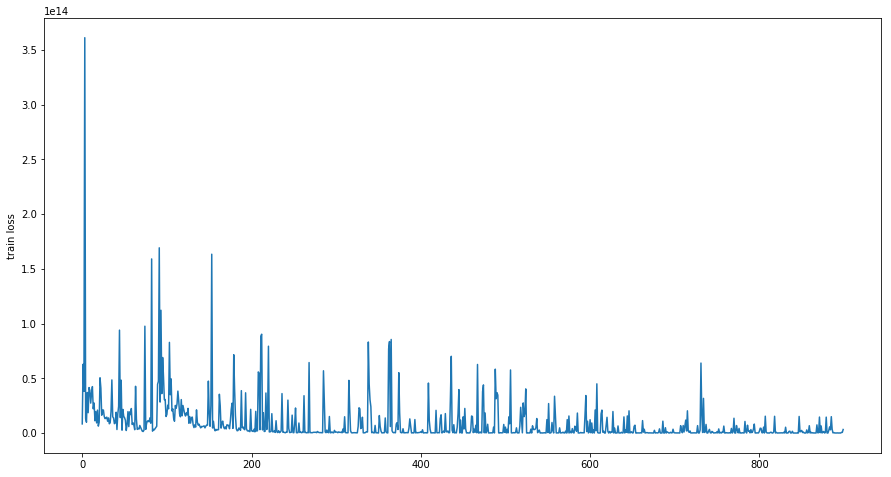

Training EM


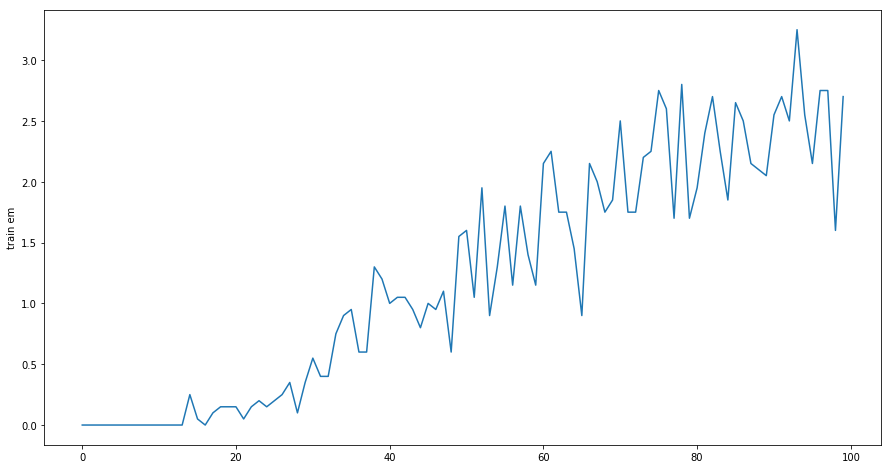

Testing EM


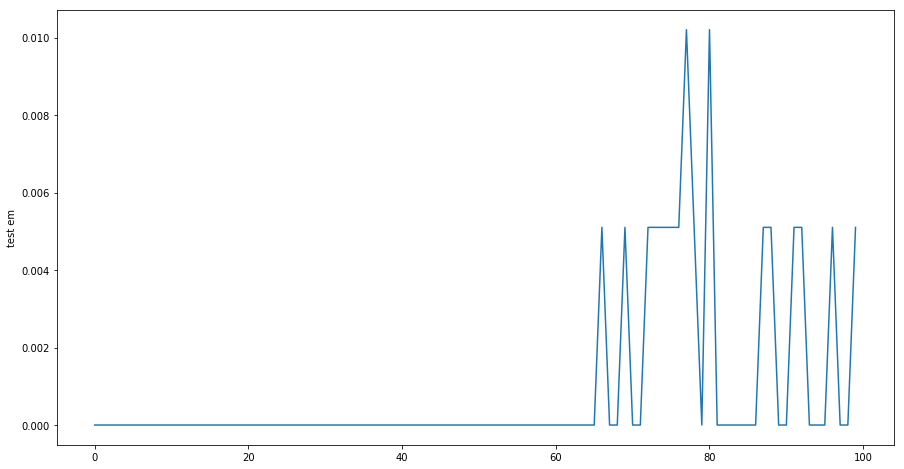

In [18]:
# Visualizations
print("Training Loss")
visualize_loss(op[0], "train loss", _only_epoch=False)

# if len(op[1]) > 0:

print("Training EM")
visualize_loss(op[1], "train em")

print("Testing EM")
visualize_loss(op[3], "test em")

